In [1]:
import pandas as pd 
from pandas import Series
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot  
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

import pmdarima as pm
from pmdarima import auto_arima 
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import datasets

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
#Importing data
Beijing = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/BeijingPM20100101_20151231.csv")

In [3]:
#Delet non-useful data
Beijing.drop(['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'season', 'precipitation', 'Iprec'], 
               axis=1,
              inplace=True)

In [4]:
Beijing.dropna(axis=0, how="any",inplace=True)

In [5]:
# from datetime import datetime
Beijing['Time'] = pd.to_datetime(Beijing['year'].map(str) +"/"+ Beijing['month'].map(str) +"/"+ Beijing['day'].map(str)+" "+Beijing['hour'].map(str)+":00:00")
#Beijing

In [6]:
#Beijing.groupby(['year']).size()

In [7]:
by_hour = Beijing.groupby(['Time']).mean()
print(by_hour.head())

                     No  year  month  day  hour  PM_US Post  DEWP  HUMI  \
Time                                                                      
2010-01-01 23:00:00  24  2010      1    1    23       129.0 -17.0  41.0   
2010-01-02 00:00:00  25  2010      1    2     0       148.0 -16.0  38.0   
2010-01-02 01:00:00  26  2010      1    2     1       159.0 -15.0  42.0   
2010-01-02 02:00:00  27  2010      1    2     2       181.0 -11.0  63.5   
2010-01-02 03:00:00  28  2010      1    2     3       138.0  -7.0  85.0   

                       PRES  TEMP   Iws  
Time                                     
2010-01-01 23:00:00  1020.0  -5.0  0.89  
2010-01-02 00:00:00  1020.0  -4.0  1.79  
2010-01-02 01:00:00  1020.0  -4.0  2.68  
2010-01-02 02:00:00  1021.0  -5.0  3.57  
2010-01-02 03:00:00  1022.0  -5.0  5.36  


In [8]:
by_hour.index = pd.to_datetime(by_hour.index, 
                             format='%d-%m-%Y %H:%M:%S')
by_hour = by_hour.set_index(by_hour.index).asfreq('H')
by_hour = by_hour.fillna(method='ffill')

print(by_hour.index)

DatetimeIndex(['2010-01-01 23:00:00', '2010-01-02 00:00:00',
               '2010-01-02 01:00:00', '2010-01-02 02:00:00',
               '2010-01-02 03:00:00', '2010-01-02 04:00:00',
               '2010-01-02 05:00:00', '2010-01-02 06:00:00',
               '2010-01-02 07:00:00', '2010-01-02 08:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Time', length=52561, freq='H')


In [9]:
by_hour['Time'] = by_hour.index
by_hour['Time']

Time
2010-01-01 23:00:00   2010-01-01 23:00:00
2010-01-02 00:00:00   2010-01-02 00:00:00
2010-01-02 01:00:00   2010-01-02 01:00:00
2010-01-02 02:00:00   2010-01-02 02:00:00
2010-01-02 03:00:00   2010-01-02 03:00:00
                              ...        
2015-12-31 19:00:00   2015-12-31 19:00:00
2015-12-31 20:00:00   2015-12-31 20:00:00
2015-12-31 21:00:00   2015-12-31 21:00:00
2015-12-31 22:00:00   2015-12-31 22:00:00
2015-12-31 23:00:00   2015-12-31 23:00:00
Freq: H, Name: Time, Length: 52561, dtype: datetime64[ns]

In [22]:
data_13 = by_hour[(by_hour['Time'] >=pd.to_datetime('20140101030000')) & (by_hour['Time'] <= pd.to_datetime('20151231030000'))]

In [23]:
data_13 = data_13.set_index(data_13.index).asfreq('d')
data_13

,No,year,month,day,hour,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,Time
Time,,,,,,,,,,,,
2014-01-01 03:00:00,35068.0,2014.0,1.0,1.0,3.0,79.0,-20.0,13.0,1013.0,6.0,153.31,2014-01-01 03:00:00
2014-01-02 03:00:00,35092.0,2014.0,1.0,2.0,3.0,172.0,-12.0,53.0,1019.0,-4.0,0.89,2014-01-02 03:00:00
2014-01-03 03:00:00,35116.0,2014.0,1.0,3.0,3.0,34.0,-9.0,47.0,1019.0,1.0,0.89,2014-01-03 03:00:00
2014-01-04 03:00:00,35140.0,2014.0,1.0,4.0,3.0,77.0,-7.0,68.0,1025.0,-2.0,1.79,2014-01-04 03:00:00
2014-01-05 03:00:00,35164.0,2014.0,1.0,5.0,3.0,183.0,-9.0,79.0,1022.0,-6.0,14.75,2014-01-05 03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27 03:00:00,52468.0,2015.0,12.0,27.0,3.0,28.0,-10.0,62.0,1039.0,-4.0,4.47,2015-12-27 03:00:00
2015-12-28 03:00:00,52492.0,2015.0,12.0,28.0,3.0,71.0,-13.0,85.0,1037.0,-11.0,11.63,2015-12-28 03:00:00
2015-12-29 03:00:00,52516.0,2015.0,12.0,29.0,3.0,326.0,-6.0,85.0,1032.0,-4.0,1.79,2015-12-29 03:00:00


In [12]:
data_13.to_csv(r'D:/Math546 Time series/project/Prep_FiveCitiePMData_MEAN/BeijingPM_cleaned.csv')

In [13]:
#by_hour.to_csv(r'D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/Beijing_by_hour.csv', index = False)

In [19]:
data = by_hour[(by_hour['Time'] >=pd.to_datetime('20130101030000')) & (by_hour['Time'] <= pd.to_datetime('20130201030000'))]
data = data.set_index(data.index).asfreq('d')
data

,No,year,month,day,hour,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,Time
Time,,,,,,,,,,,,
2013-01-01 03:00:00,26308.0,2013.0,1.0,1.0,3.0,16.0,-14.0,72.0,1018.0,-10.0,14.75,2013-01-01 03:00:00
2013-01-02 03:00:00,26332.0,2013.0,1.0,2.0,3.0,17.0,-28.0,25.0,1035.0,-12.0,156.03,2013-01-02 03:00:00
2013-01-03 03:00:00,26356.0,2013.0,1.0,3.0,3.0,20.0,-28.0,25.0,1046.0,-12.0,375.07,2013-01-03 03:00:00
2013-01-04 03:00:00,26380.0,2013.0,1.0,4.0,3.0,56.0,-22.0,65.0,1038.0,-17.0,20.13,2013-01-04 03:00:00
2013-01-05 03:00:00,26404.0,2013.0,1.0,5.0,3.0,78.0,-22.0,50.0,1028.0,-14.0,3.13,2013-01-05 03:00:00
2013-01-06 03:00:00,26428.0,2013.0,1.0,6.0,3.0,40.0,-18.0,56.0,1030.0,-11.0,7.15,2013-01-06 03:00:00
2013-01-07 03:00:00,26452.0,2013.0,1.0,7.0,3.0,128.0,-16.0,72.0,1025.0,-12.0,8.05,2013-01-07 03:00:00
2013-01-08 03:00:00,26476.0,2013.0,1.0,8.0,3.0,402.0,-14.0,67.0,1029.0,-9.0,3.57,2013-01-08 03:00:00
2013-01-09 03:00:00,26500.0,2013.0,1.0,9.0,3.0,24.0,-21.0,47.0,1033.0,-12.0,11.17,2013-01-09 03:00:00


In [16]:
# take aDFuller test the statioinarity of  the timeseries
def test_stationarity(timeseries):
 #Determing rolling statistics
    rolmean=pd.Series.rolling(timeseries,window=12).mean()
 #rolmean=pd.rolling_mean(timeseries,window=12)
 #rolstd=pd.rolling_std(timeseries,window=12)
    rolstd=pd.Series.rolling(timeseries,window=12).std()
 
 #plot rolling statistics
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling mean')
    std=plt.plot(rolstd,color='black',label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean & Standard Deviatiom')
    plt.show(block=False)
 
 #perfprmance Dickey_Fuller Test
    print('Resluts of Dickey-Fuller Test:')
    dftest=adfuller(timeseries,autolag='AIC')
    dfountput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','Number of obervations used'])
 
    for key,value in dftest[4].items():
        dfountput['Critical Value(%s)'%key]=value      
    print(dfountput)
# 

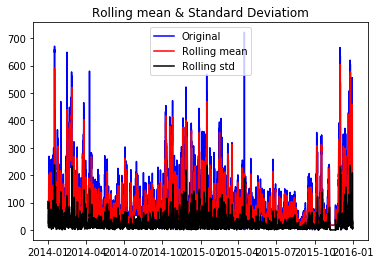

Resluts of Dickey-Fuller Test:
Test Statistic               -1.344292e+01
p-value                       3.814030e-25
#lags used                    3.900000e+01
Number of obervations used    1.745700e+04
Critical Value(1%)           -3.430725e+00
Critical Value(5%)           -2.861706e+00
Critical Value(10%)          -2.566858e+00
dtype: float64


In [17]:
test_stationarity(data_13['PM_US Post'])

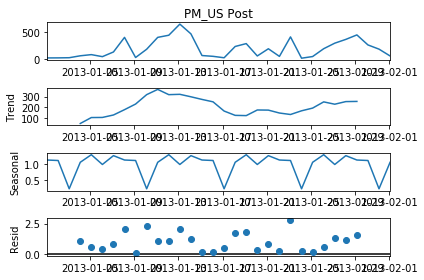

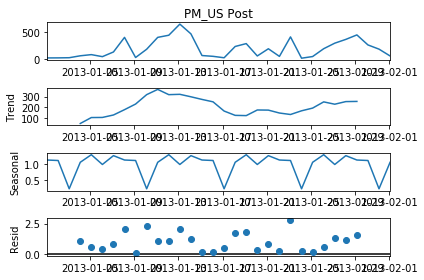

In [20]:
result = seasonal_decompose(data['PM_US Post'],  
                            model ='multiplicative') 
  
# ETS plot  
result.plot()

In [24]:
len(data_13)

730

In [25]:
# Split data into train / test sets 
train = data_13['PM_US Post'].iloc[:len(data_13)-156] 
test = data_13['PM_US Post'].iloc[len(data_13)-156:]

In [27]:
# Fit auto_arima function to dataset 
stepwise_fit = auto_arima(train, start_p = 0, start_q = 0, 
                          max_p = 4, max_q = 4, m=52,
                          start_P = 0, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise  

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 52) (constant=True); AIC=6289.058, BIC=6301.831, Time=31.301 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=6520.597, BIC=6529.112, Time=0.611 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 52) (constant=True); AIC=6311.779, BIC=6328.809, Time=40.725 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 52) (constant=True); AIC=6188.272, BIC=6205.303, Time=51.604 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=False); AIC=6520.739, BIC=6524.997, Time=0.439 seconds
Fit ARIMA: (0, 0, 0)x(1, 1, 1, 52) (constant=True); AIC=6291.046, BIC=6308.077, Time=46.418 seconds
Near non-invertible roots for order (0, 0, 0)(1, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 2, 52) (cons

In [28]:
# To print the summary 
stepwise_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  574
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood               -3088.776
Date:                            Tue, 14 Apr 2020   AIC                           6187.553
Time:                                    12:24:14   BIC                           6208.841
Sample:                                         0   HQIC                          6195.891
                                            - 574                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -4.1381      1.625     -2.547      0.011      -7.322      -0.954
ar.L1          0.1573      0.083      1.905      0.057      -0.005       0.319
ma.L1          0.3103      0.085      3.661      0.000       0.144       0.476
ma.S.L52      -0.9986      6.861     -0.146      0.884     -14.447      12.450
sigma2      6383.2792   4.37e+04      0.146      0.884   -7.93e+04    9.21e+04
===================================================================================
Ljung-Box (Q):                       68.46   Jarque-Bera (JB):                51.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# Fit a SARIMAX(1, 0, 1)x(0, 1, [1], 7)on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train,  
                order = (1, 0, 1),  
                seasonal_order =(0, 1, 1, 52))

In [30]:
result = model.fit() 

In [31]:
 result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         PM_US Post   No. Observations:                  574
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood               -3093.148
Date:                            Tue, 14 Apr 2020   AIC                           6194.296
Time:                                    12:30:28   BIC                           6211.327
Sample:                                01-01-2014   HQIC                          6200.967
                                     - 07-28-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1996      0.080      2.497      0.013       0.043       0.356
ma.L1          0.2869      0.083      3.440      0.001       0.123       0.450
ma.S.L52      -0.9993     14.693     -0.068      0.946     -29.797      27.798
sigma2      6489.8886   9.53e+04      0.068      0.946    -1.8e+05    1.93e+05
===================================================================================
Ljung-Box (Q):                       66.33   Jarque-Bera (JB):                46.97
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

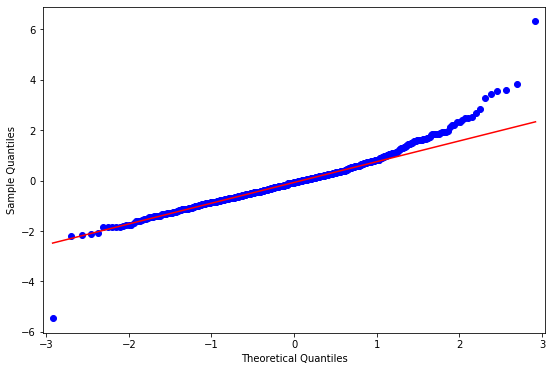

In [32]:
resid = result.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

In [36]:
len(test)

156

predict_ARMA = result.predict(start =575, end = 750) 
#print(predict_ARIMA) 

plt.figure(figsize=(12,9)) 
orig = plt.plot(test, color='blue', label='Original') 
pred = plt.plot(predict_ARMA, color='red', label='Prediction' ) 
plt.legend(loc='best') 
plt.title('Origianl vs. Prediction') 
plt.show(block=False) 

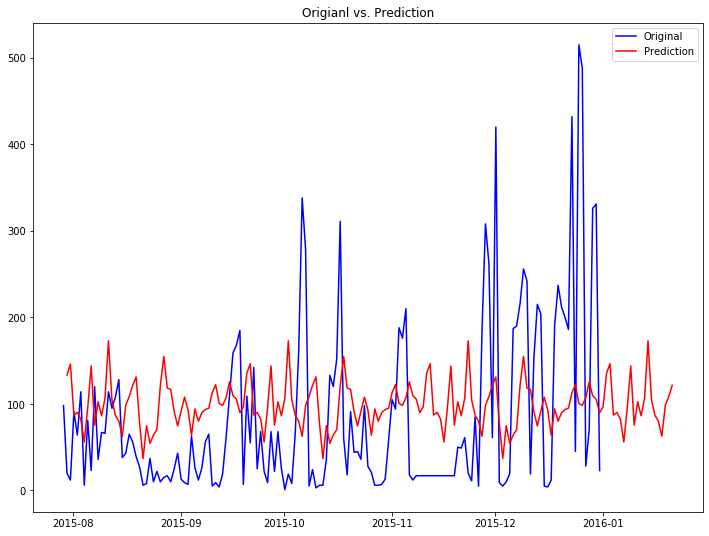

In [35]:
predict_ARMA = result.predict(start =575, end = 750) 
#print(predict_ARIMA) 
plt.figure(figsize=(12,9)) 
orig = plt.plot(test, color='blue', label='Original') 
pred = plt.plot(predict_ARMA, color='red', label='Prediction' ) 
plt.legend(loc='best') 
plt.title('Origianl vs. Prediction') 
plt.show(block=False) 